In [15]:
import torch
from torcheval.metrics.text import Perplexity
import random
from tqdm import tqdm
from data_utils import compute_normalized_token_entropy
import random
import numpy as np
import os
from transformers import get_cosine_schedule_with_warmup
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from GridMLM_tokenizers import CSGridMLMTokenizer
from torch.utils.data import DataLoader
from models import DualGridMLMMelHarm
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from train_utils import train_with_curriculum, apply_masking, full_to_partial_masking
import matplotlib.pyplot as plt
from generate_utils import generate_files_with_greedy, generate_files_with_beam, load_model

In [16]:
tokenizer = CSGridMLMTokenizer(
    fixed_length=80,
    quantization='4th',
    intertwine_bar_info=True,
    trim_start=False,
    use_pc_roll=True,
    use_full_range_melody=False
)

In [17]:
# train_dir = '/media/maindisk/data/synthetic_CA_train'
# val_dir = '/media/maindisk/data/synthetic_CA_test'
val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
batchsize = 2

In [18]:
# train_dataset = CSGridMLMDataset(train_dir, tokenizer, name_suffix='DE')
val_dataset = CSGridMLMDataset(val_dir, tokenizer, name_suffix='DE')

# trainloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=CSGridMLM_collate_fn)
valloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False, collate_fn=CSGridMLM_collate_fn)

Loading data file.


In [19]:
device_name = 'cuda:0'
if device_name == 'cpu':
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)

In [20]:
loss_fn=CrossEntropyLoss(ignore_index=-100)
lr = 1e-5

In [21]:
curriculum_type , total_stages = 'f2f', 5
subfolder = 'DE/CA'

model = load_model(
    d_model=512, 
    nhead=4, 
    num_layers_mel=4,
    num_layers_harm=4,
    curriculum_type=curriculum_type,
    subfolder=subfolder,
    device_name=device_name,
    tokenizer=tokenizer,
    melody_length=80,
    harmony_length=80,
)

# model.to(device)
optimizer = AdamW(model.parameters(), lr=lr)

In [22]:
batch = next(iter(valloader))
model.train()

DualGridMLMMelHarm(
  (melody_proj): Linear(in_features=13, out_features=512, bias=True)
  (harmony_embedding): Embedding(355, 512)
  (melody_encoder): SimpleTransformerStack(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (harmony_encoder): HarmonyTransformerStack(
    (layers): ModuleList(
      (0-3): 4 x HarmonyEncoderLayerWithCross(
        (self_attn): MultiheadA

In [ ]:
melody_grid = batch["pianoroll"].to(device)           # (B, 256, 100)
harmony_gt = batch["harmony_ids"].to(device)         # (B, 256)

torch.Size([2, 80, 13])
torch.Size([2, 80])
torch.Size([2, 80, 512])


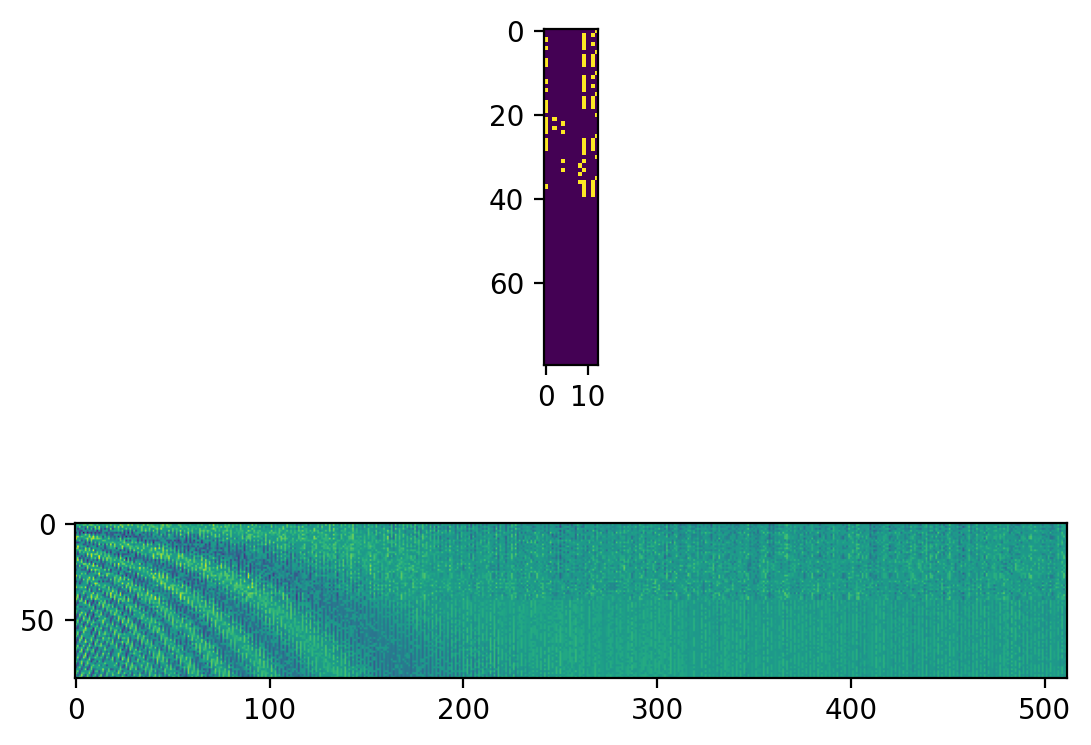

In [24]:
print(melody_grid.shape)
print(harmony_gt.shape)
mel = model.melody_proj(melody_grid)  # (B, 256, 512)
mel = mel + model.shared_pos[:, :model.melody_length, :]
mel = model.input_norm(mel)
mel = model.dropout(mel)
print(mel.shape)
plt.subplot(2, 1, 1)
plt.imshow(melody_grid[0].detach().cpu())
plt.subplot(2, 1, 2)
plt.imshow(mel[0].detach().cpu())

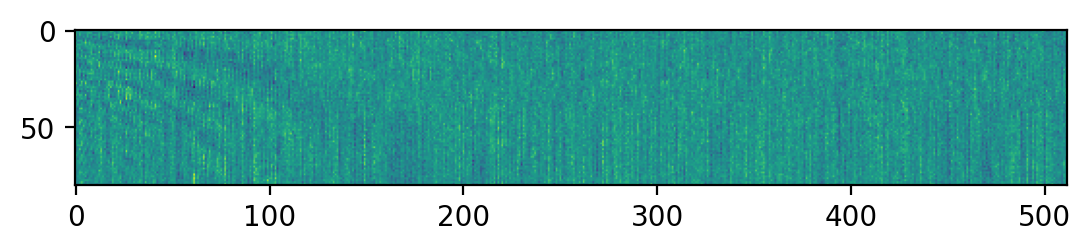

In [25]:
plt.imshow(model.melody_encoder(mel).detach().cpu()[0])

In [26]:
mask_token_id = tokenizer.mask_token_id
bar_token_id = tokenizer.bar_token_id
curriculum_type = 'random'

In [28]:
# rets = apply_masking(
#     harmony_gt,
#     mask_token_id,
#     total_stages=total_stages,
#     curriculum_type=curriculum_type,
#     bar_token_id=bar_token_id
# )
rets = full_to_partial_masking(
    harmony_gt,
    mask_token_id,
    0,
    bar_token_id=bar_token_id
)

In [29]:
harmony_input, harmony_target = rets[0], rets[1]
# # # DEBUG
# harmony_target = harmony_gt.clone()
# harmony_input = harmony_gt.clone()
# harmony_input[:,0:10] = mask_token_id
# harmony_input[:,:] = mask_token_id

In [30]:
print(harmony_input[0,:])
print(harmony_target[0,:])
# print(stage_indices)

tensor([6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5,
        5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')
tensor([  6, 269, 269, 269, 269,   6, 152, 152,  66,  66,   6, 269, 269, 269,
        269,   6, 152, 152,  66,  66,   6, 269, 269, 269, 269,   6, 152, 152,
         66,  66,   6, 269, 269, 269, 269,   6, 152, 152,  66,  66,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')


In [31]:
for i in range(harmony_input.shape[1]):
    print(harmony_gt[0][i].item(), harmony_input[0,i].item(), harmony_target[0,i].item())

6 6 6
269 5 269
269 5 269
269 5 269
269 5 269
6 6 6
152 5 152
152 5 152
66 5 66
66 5 66
6 6 6
269 5 269
269 5 269
269 5 269
269 5 269
6 6 6
152 5 152
152 5 152
66 5 66
66 5 66
6 6 6
269 5 269
269 5 269
269 5 269
269 5 269
6 6 6
152 5 152
152 5 152
66 5 66
66 5 66
6 6 6
269 5 269
269 5 269
269 5 269
269 5 269
6 6 6
152 5 152
152 5 152
66 5 66
66 5 66
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1
1 5 1


In [32]:
print(tokenizer.vocab)

{'<unk>': 0, '<pad>': 1, '<s>': 2, '</s>': 3, '<nc>': 4, '<mask>': 5, '<bar>': 6, 'C:maj': 7, 'C:min': 8, 'C:aug': 9, 'C:dim': 10, 'C:sus4': 11, 'C:sus2': 12, 'C:7': 13, 'C:maj7': 14, 'C:min7': 15, 'C:minmaj7': 16, 'C:maj6': 17, 'C:min6': 18, 'C:dim7': 19, 'C:hdim7': 20, 'C:maj9': 21, 'C:min9': 22, 'C:9': 23, 'C:min11': 24, 'C:11': 25, 'C:maj13': 26, 'C:min13': 27, 'C:13': 28, 'C:1': 29, 'C:5': 30, 'C': 31, 'C:7(b9)': 32, 'C:7(#9)': 33, 'C:7(#11)': 34, 'C:7(b13)': 35, 'C#:maj': 36, 'C#:min': 37, 'C#:aug': 38, 'C#:dim': 39, 'C#:sus4': 40, 'C#:sus2': 41, 'C#:7': 42, 'C#:maj7': 43, 'C#:min7': 44, 'C#:minmaj7': 45, 'C#:maj6': 46, 'C#:min6': 47, 'C#:dim7': 48, 'C#:hdim7': 49, 'C#:maj9': 50, 'C#:min9': 51, 'C#:9': 52, 'C#:min11': 53, 'C#:11': 54, 'C#:maj13': 55, 'C#:min13': 56, 'C#:13': 57, 'C#:1': 58, 'C#:5': 59, 'C#': 60, 'C#:7(b9)': 61, 'C#:7(#9)': 62, 'C#:7(#11)': 63, 'C#:7(b13)': 64, 'D:maj': 65, 'D:min': 66, 'D:aug': 67, 'D:dim': 68, 'D:sus4': 69, 'D:sus2': 70, 'D:7': 71, 'D:maj7': 72,

In [33]:
logits = model(
    melody_grid.to(device),
    # harmony_gt.to(device),
    harmony_input.to(device),
    # stage_indices.to(device),
    None
)

In [34]:
print(logits.argmax(dim=-1)[0,:])
print(harmony_gt[0])

tensor([  6, 269, 269, 159, 269,   6, 152, 152, 269, 269,   6, 159, 159, 269,
        269,   6,  71, 152,  71, 194,   6, 269, 269, 269,  73,   6, 152, 269,
        269, 269,   6, 123, 123, 123, 123,   6, 182, 123, 273,  95,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')
tensor([  6, 269, 269, 269, 269,   6, 152, 152,  66,  66,   6, 269, 269, 269,
        269,   6, 152, 152,  66,  66,   6, 269, 269, 269, 269,   6, 152, 152,
         66,  66,   6, 269, 269, 269, 269,   6, 152, 152,  66,  66,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')


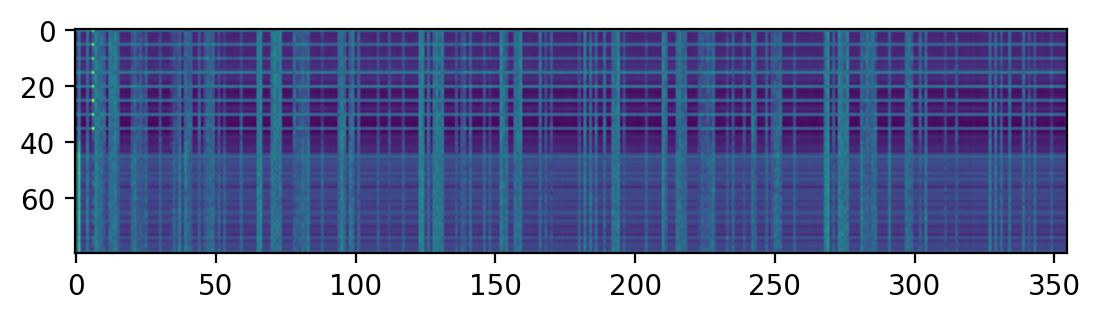

In [35]:
plt.imshow(logits[0].detach().cpu())

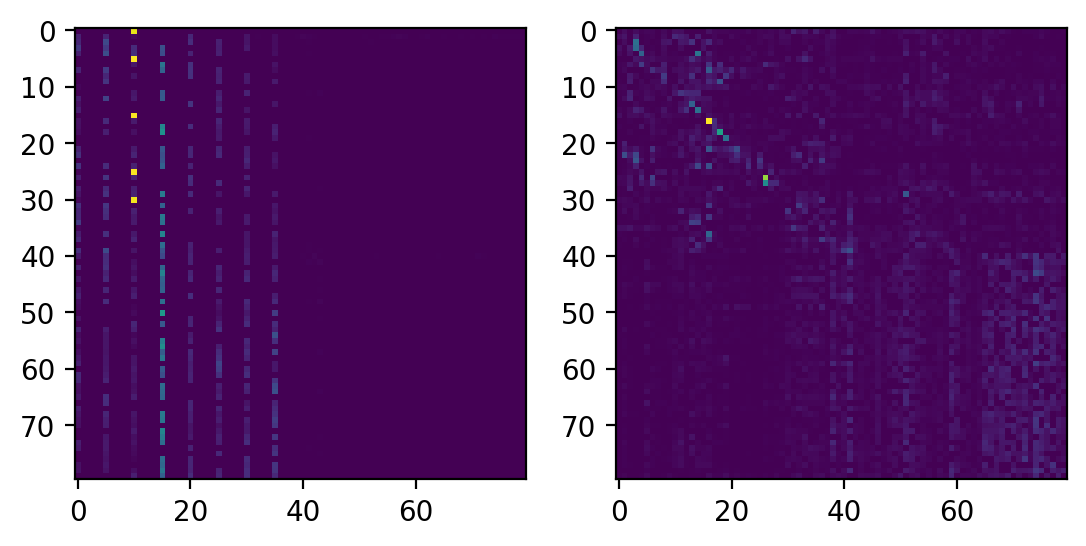

In [36]:
self_attns, cross_attns = model.get_attention_maps()
plt.subplot(1, 2, 1)
plt.imshow(self_attns[0][0,0].detach().cpu())
plt.subplot(1, 2, 2)
plt.imshow(cross_attns[3][0,0].detach().cpu())

In [37]:
loss = loss_fn(logits.view(-1, logits.size(-1)), harmony_target.view(-1))
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [38]:
# plt.imshow(model.melody_proj.weight.grad.detach().cpu())
print(model.melody_proj.weight.grad.norm())
# print(model.stage_proj.weight.grad.norm())
print(model.output_head.weight.grad.norm())
# print(model.harmony_encoder.weight.grad.norm())

tensor(0.1936, device='cuda:0')
tensor(2.4897, device='cuda:0')


In [39]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.norm().item())

melody_proj.weight 0.1935921311378479
melody_proj.bias 0.19943872094154358
harmony_embedding.weight 0.20829549431800842
melody_encoder.layers.0.self_attn.in_proj_weight 0.9012552499771118
melody_encoder.layers.0.self_attn.in_proj_bias 0.08565112948417664
melody_encoder.layers.0.self_attn.out_proj.weight 0.850176990032196
melody_encoder.layers.0.self_attn.out_proj.bias 0.0990099385380745
melody_encoder.layers.0.linear1.weight 0.7398247718811035
melody_encoder.layers.0.linear1.bias 0.041842374950647354
melody_encoder.layers.0.linear2.weight 0.8025017380714417
melody_encoder.layers.0.linear2.bias 0.11327816545963287
melody_encoder.layers.0.norm1.weight 0.07200250029563904
melody_encoder.layers.0.norm1.bias 0.11596573144197464
melody_encoder.layers.0.norm2.weight 0.10218411684036255
melody_encoder.layers.0.norm2.bias 0.17237167060375214
melody_encoder.layers.1.self_attn.in_proj_weight 1.0575159788131714
melody_encoder.layers.1.self_attn.in_proj_bias 0.10881051421165466
melody_encoder.layer

In [40]:
def plot_grad_flow(named_parameters):
    ave_grads, layers = [], []
    for n, p in named_parameters:
        if p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.7, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k")
    plt.xticks(range(0,len(ave_grads),1), layers, rotation="vertical")
    plt.xlim(0, len(ave_grads))
    plt.ylim(bottom=0)
    plt.show()


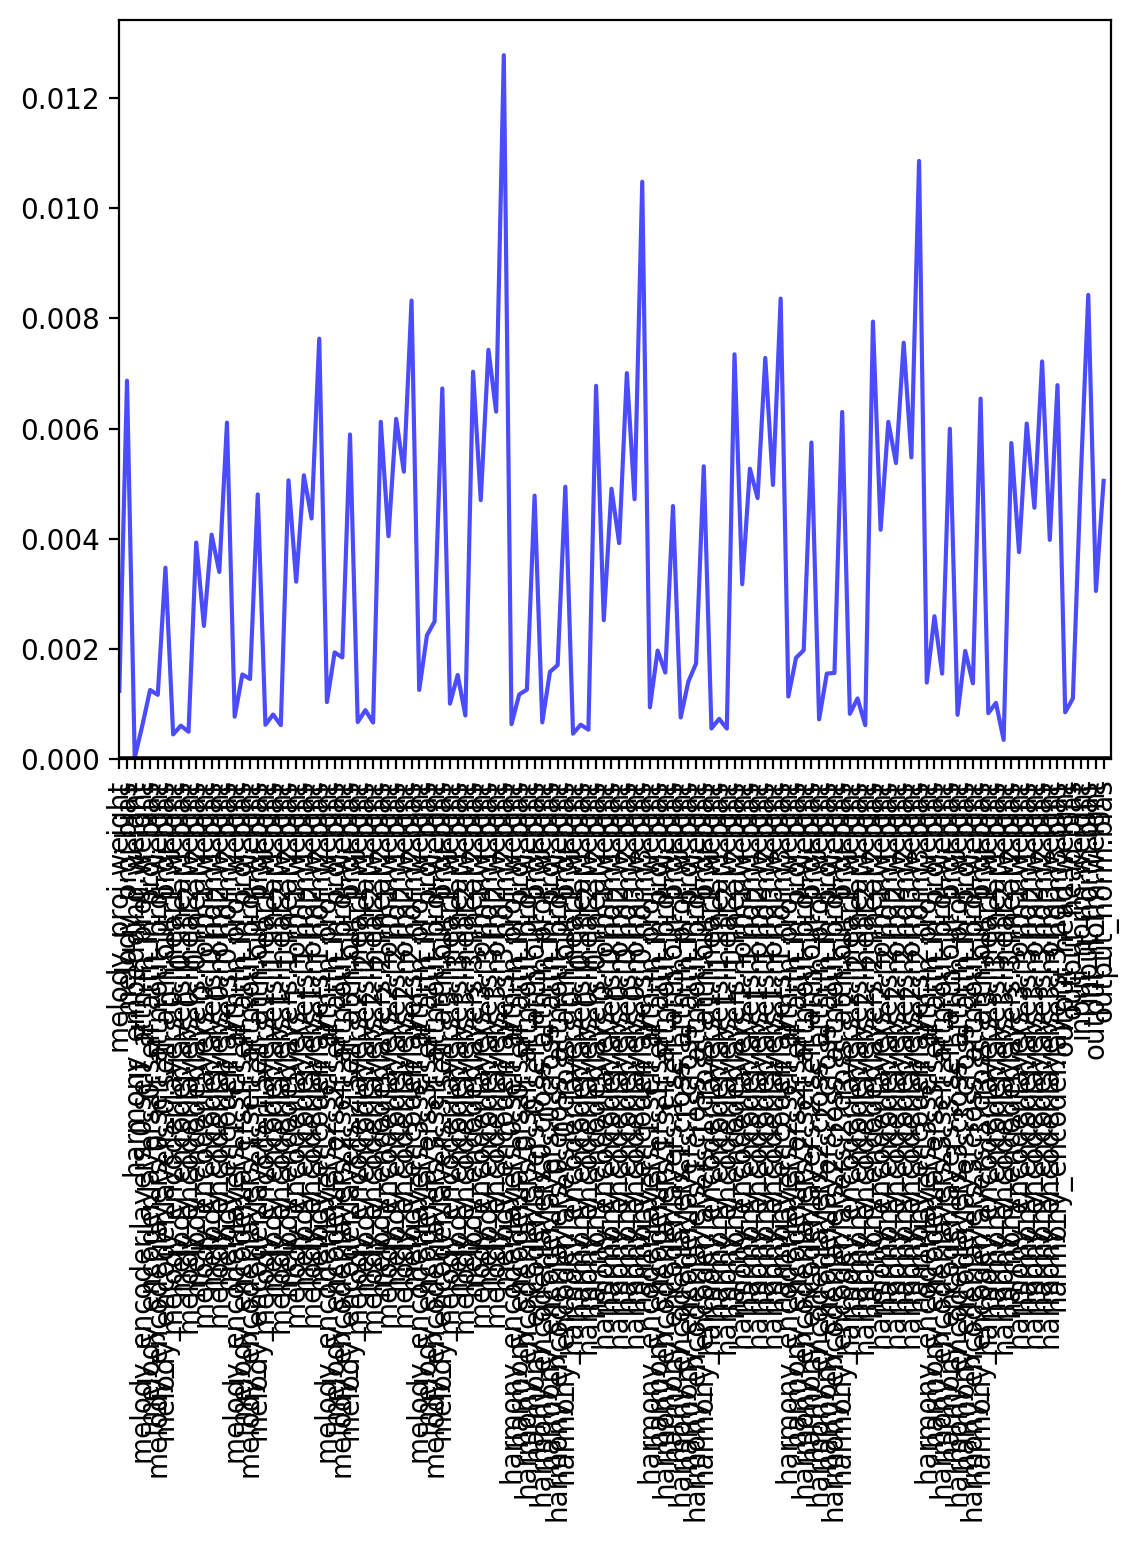

In [41]:
plot_grad_flow(model.named_parameters())

In [42]:
self_attns, cross_attns = model.get_attention_maps()

In [43]:
for i, ca in enumerate(cross_attns):
    if ca is None:
        print(f"layer {i}: cross_attn is None")
    else:
        # ca shape should be (B, nhead, Lh, Lm)
        print(f"layer {i}: cross_attn shape {tuple(ca.shape)}, mean={ca.abs().mean().item():.6f}, max={ca.abs().max().item():.6f}")
        # show mean over heads for harmony position 0 → melody positions
        mean_over_heads = ca.mean(dim=1)   # (B, Lh, Lm)
        print("layer", i, "example mean over heads for sample 0 harmony pos 0:", mean_over_heads[0, 0, :10])

layer 0: cross_attn shape (2, 4, 80, 80), mean=0.012573, max=1.283769
layer 0 example mean over heads for sample 0 harmony pos 0: tensor([0.0676, 0.0491, 0.0597, 0.0579, 0.0112, 0.0059, 0.0165, 0.0003, 0.0017,
        0.0083], device='cuda:0')
layer 1: cross_attn shape (2, 4, 80, 80), mean=0.012617, max=1.217929
layer 1 example mean over heads for sample 0 harmony pos 0: tensor([0.0877, 0.0000, 0.0377, 0.1317, 0.0104, 0.0047, 0.0061, 0.0039, 0.0049,
        0.0045], device='cuda:0')
layer 2: cross_attn shape (2, 4, 80, 80), mean=0.012377, max=0.980018
layer 2 example mean over heads for sample 0 harmony pos 0: tensor([0.0384, 0.0438, 0.0128, 0.0944, 0.0037, 0.0048, 0.0071, 0.0062, 0.0084,
        0.0135], device='cuda:0')
layer 3: cross_attn shape (2, 4, 80, 80), mean=0.012440, max=0.664116
layer 3 example mean over heads for sample 0 harmony pos 0: tensor([0.0126, 0.0069, 0.0082, 0.0156, 0.0086, 0.0088, 0.0053, 0.0009, 0.0181,
        0.0055], device='cuda:0')


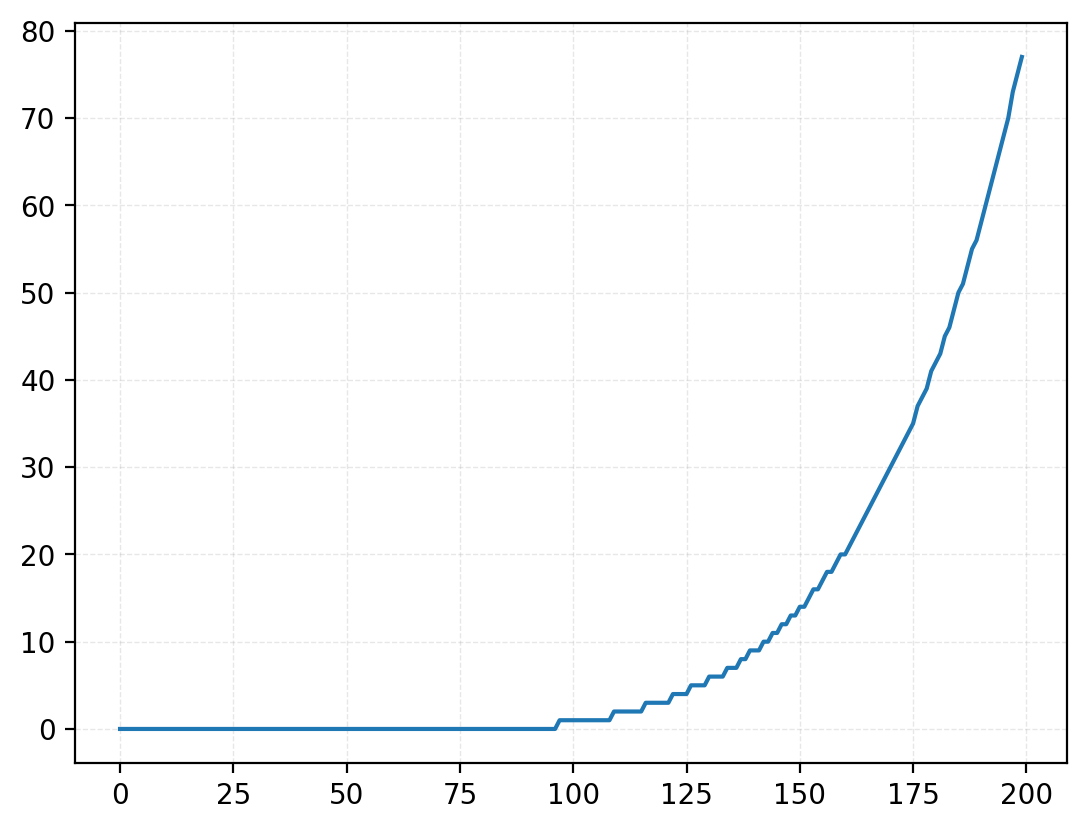

In [46]:
plt.plot( np.floor(((np.arange(0,200,1)/200)**6)*80) )
plt.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)